# EDA for roletheme models

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
meta = pd.read_csv('../../metadata/filtered_fiction_plus_18c.tsv', sep = '\t', index_col = 'docid')
meta = meta[~meta.index.duplicated(keep = 'first')]

In [5]:
# read the doctopic distributions

doctopic_path = '../roletheme/sixthmodelIII_doctopics.tsv'
charvectors = dict()
yearcollections = dict()

with open(doctopic_path, encoding = 'utf-8') as f:
    for line in f:
        fields = line.strip().split('\t')
        if fields[0] == 'book':
            continue
        charid = fields[1]
        docid = charid.split('|')[0]
        if docid not in meta.index:
            print('error: ', docid)
            continue
        else:
            yr = meta.loc[docid, 'inferreddate']
        
        vector = np.array([int(float(x)) for x in fields[3:]], dtype = 'int32')
        charvectors[charid] = vector
        if yr not in yearcollections:
            yearcollections[yr] = []
        yearcollections[yr].append(vector)

error


In [8]:
yeardists = dict()
yrmax = 0
yrmin = 3000

for yr, collex in yearcollections.items():
    if yr > yrmax:
        yrmax = yr
    if yr < yrmin:
        yrmin = yr
    
    charsum = np.sum(collex, axis = 0)
    dist = charsum / np.sum(charsum)
    yeardists[yr] = dist

yearspan = yrmax - yrmin
    
topicdists = dict()
for i in range(len(dist)):
    topicdists[i] = np.zeros(yearspan + 1)
    
for yr in range(yrmin, yrmax + 1):
    for idx, value in enumerate(yeardists[yr]):
        topicdists[idx][yr - yrmin] = value
        
    

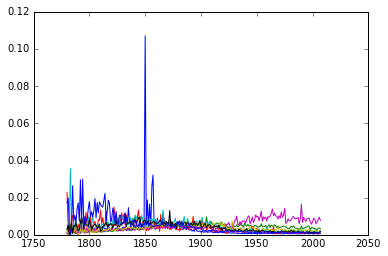

In [12]:
xaxis = [x for x in range(yrmin, yrmax + 1)]

for i in range(80, 88):
    plt.plot(xaxis, topicdists[i])

plt.show()

In [14]:
numtopics = len(dist)
numtopics

240

In [13]:
# from Olivia Guest
# https://github.com/oliviaguest/gini

import numpy as np

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))


In [15]:
ginis = []

for topic in range(numtopics):
    ginis.append(gini(topicdists[topic]))

In [16]:
np.mean(ginis[0:60])

0.38929352277079848

In [17]:
np.mean(ginis[60: ])

0.32898731529071001

In [18]:
np.std(ginis)

0.14075978899366212

In [20]:
from scipy.stats import ttest_ind

In [21]:
ttest_ind(ginis[0:60], ginis[60: ], equal_var = False)

Ttest_indResult(statistic=2.5059210838104331, pvalue=0.014206687638479236)

In [22]:
# So the themes are significantly more concentrated on the x axis than the roles

In [24]:
topicsizes = np.zeros(numtopics)

for yr, collex in yearcollections.items():
    charsum = np.sum(collex, axis = 0)
    topicsizes = topicsizes + charsum

topicsizes = topicsizes / np.sum(topicsizes)

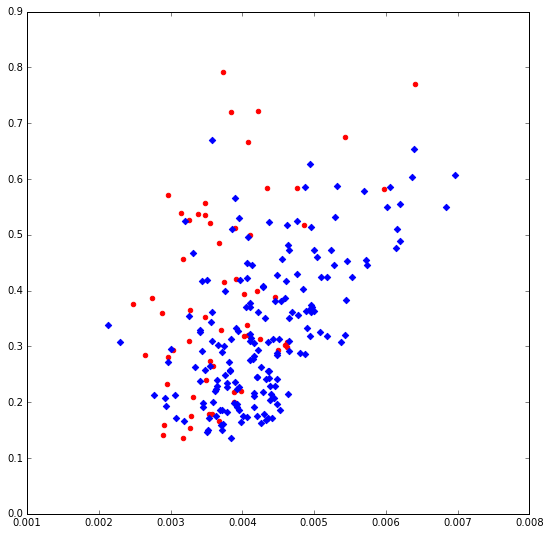

In [30]:
plt.figure(figsize = (9, 9))
plt.scatter(topicsizes[0:60], ginis[0:60], marker = 'o', color = 'r')
plt.scatter(topicsizes[60:], ginis[60:], marker = 'D', color = 'b')
plt.xlim(0.001, 0.008)
plt.show()